# 1- Install & Import necessary libraries

In [ ]:
! pip install protobuf
! pip install transformers[torch]
! pip install sentencepiece
! pip install transformers
! pip install accelerate
! pip install accelerate -U
! pip install wandb
! pip install matplotlib
! pip install evaluate[evaluator]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 115.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any

# 2- Import and Analyse SQuAD Dataset

In [1]:
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
from transformers import AutoTokenizer, pipeline, AutoModelForQuestionAnswering, DefaultDataCollator, BigBirdTokenizerFast, TrainingArguments, Trainer
from huggingface_hub import notebook_login
import torch
import collections
import string
import re
from evaluate import evaluator
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')


In [117]:
# Load the SQuAD 2.0 dataset
dataset = load_dataset('squad_v2')


Found cached dataset squad_v2 (C:/Users/Fred/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [ ]:
import os

os.environ["WANDB_PROJECT"] = "bigbird-QA-squad_v2" # ! enter your project name here 


In [ ]:
import wandb

wandb.init(
    project="docqa",
)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
notebook_login() # code

In [ ]:
### Functions ### 

# Function to check if a question has an answer
def is_answerable(example):
    return len(example['answers']['text']) > 0

# Function to calculate word length of answerable questions and their answers
def calculate_answerable_lengths(data, split_name):
    answerable_data = [item for item in data if is_answerable(item)]
    question_lengths = [len(q.split()) for q in (item['question'] for item in answerable_data)]
    answer_lengths = [len(item['answers']['text'][0].split()) for item in answerable_data]
    
    return pd.DataFrame({
        'Type': ['Question']*len(question_lengths) + ['Answer']*len(answer_lengths),
        'Length': question_lengths + answer_lengths,
        'Split': [split_name]*(len(question_lengths) + len(answer_lengths))
    })
    
    
# Extract the first word of each question
def get_question_type(question):
    words = question.split()
    return ' '.join(words[:2]).lower() if words[0].lower() == 'in' else words[0].lower()

    

In [ ]:
### Data Exploration ###
min_length = np.min(unique_context_lengths)
max_length = np.max(unique_context_lengths)
mean_length = np.mean(unique_context_lengths)
median_length = np.median(unique_context_lengths)
std_dev_length = np.std(unique_context_lengths)
unique_number = len(unique_context_lengths)


print(f"Summary of Unique Context Lengths:")
print(f"Minimum Length: {min_length} words")
print(f"Maximum Length: {max_length} words")
print(f"Mean Length: {mean_length:.2f} words")
print(f"Median Length: {median_length} words")
print(f"Standard Deviation: {std_dev_length:.2f} words")
print(f"Unique Number: {unique_number}")

Summary of Unique Context Lengths:
Minimum Length: 20 words
Maximum Length: 653 words
Mean Length: 116.60 words
Median Length: 107.0 words
Standard Deviation: 49.67 words
Unique Number: 19029


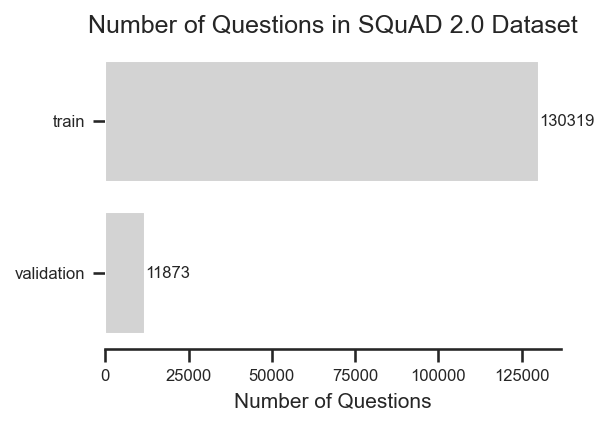

In [86]:
### Dataset Distribution ###
question_counts = {split: len(dataset[split]['question']) for split in dataset.keys()}

# Plot the number of questions in each split
plt.figure(figsize=(4, 3), dpi=150)
bars = sns.barplot(y=list(question_counts.keys()), x=list((question_counts.values())), color='lightgray')

plt.title('Number of Questions in SQuAD 2.0 Dataset')
plt.xlabel('Number of Questions', fontsize=10)
plt.ylabel('')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

for bar in bars.patches:
    plt.text(
        bar.get_width(),       
        bar.get_y() + bar.get_height() / 2,  
        f'{int(bar.get_width())}',  
        va='center',           
        ha='left',             
        fontsize=8
    )

sns.despine(left=True)    
plt.show()


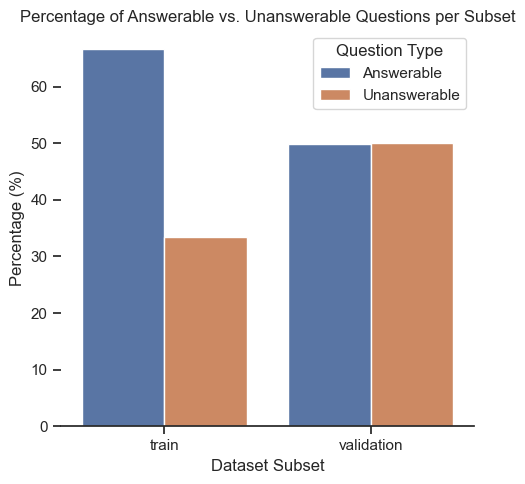

In [97]:
### Question Type Distribution ###

# Process the data and calculate percentages
data = []
for split in dataset.keys():
    split_data = dataset[split]
    num_examples = len(split_data)
    num_answerable = sum(is_answerable(example) for example in split_data)
    num_unanswerable = num_examples - num_answerable
    data.extend([
        {'split': split, 'question_type': 'Answerable', 'percentage': (num_answerable / num_examples) * 100},
        {'split': split, 'question_type': 'Unanswerable', 'percentage': (num_unanswerable / num_examples) * 100}
    ])
df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(5, 5))
sns.barplot(data=df, x='split', y='percentage', hue='question_type')
plt.title('Percentage of Answerable vs. Unanswerable Questions per Subset')
plt.xlabel('Dataset Subset')
plt.ylabel('Percentage (%)')
plt.legend(title='Question Type')
plt.tight_layout()
sns.despine(left=True)    
plt.show()


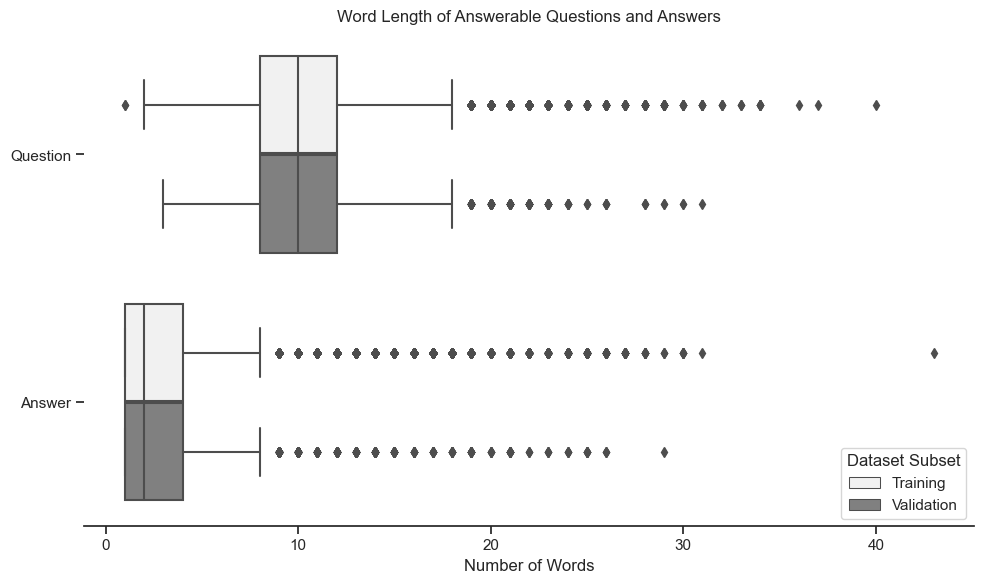

In [131]:
### Answer Length Distribution ###

# Calculate lengths for training and validation sets
train_lengths_df = calculate_answerable_lengths(dataset['train'], 'Training')
validation_lengths_df = calculate_answerable_lengths(dataset['validation'], 'Validation')
lengths_df = pd.concat([train_lengths_df, validation_lengths_df])

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=lengths_df, x='Length', y='Type', hue='Split', color='grey', saturation=0.8)

plt.title('Word Length of Answerable Questions and Answers')
plt.xlabel('Number of Words')
plt.ylabel('')
plt.legend(title='Dataset Subset')
sns.despine(left=True)
plt.tight_layout()
plt.show()


## Top Question Types in SQuAD 2.0 Dataset

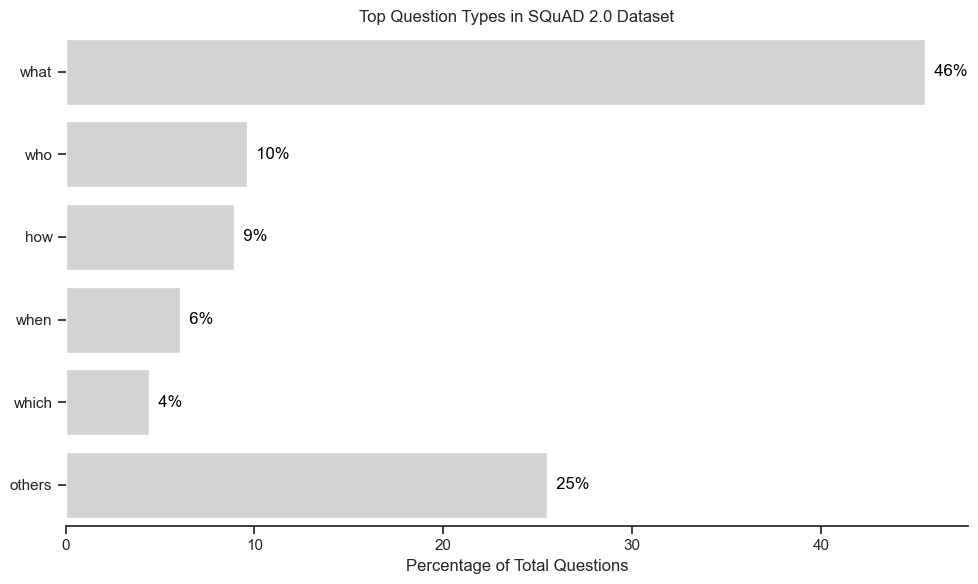

In [201]:
# Analyse the distribution of question types
question_types = Counter(get_question_type(q) for q in dataset['train']['question'])
top_question_types = question_types.most_common(5)
other_count = sum(count for word, count in question_types.items() if word not in dict(top_question_types))
top_question_types.append(('others', other_count))
total_questions = sum(question_types.values())

# Plotting the distribution
types = [t[0] for t in top_question_types]
counts = [t[1] for t in top_question_types]
percentages = [(count / total_questions) * 100 for count in counts]
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=percentages, y=types, color='lightgrey')
plt.title('Top Question Types in SQuAD 2.0 Dataset')
plt.xlabel('Percentage of Total Questions')
plt.ylabel('')
for i, percentage in enumerate(percentages):
    plt.text(percentage, i, f'  {percentage:.0f}%', va='center', ha='left', color='black')
sns.despine(left=True)
plt.tight_layout()
plt.show()


## Percentage Distribution of Unique Articles Lengths in SQuAD 2.0 Dataset

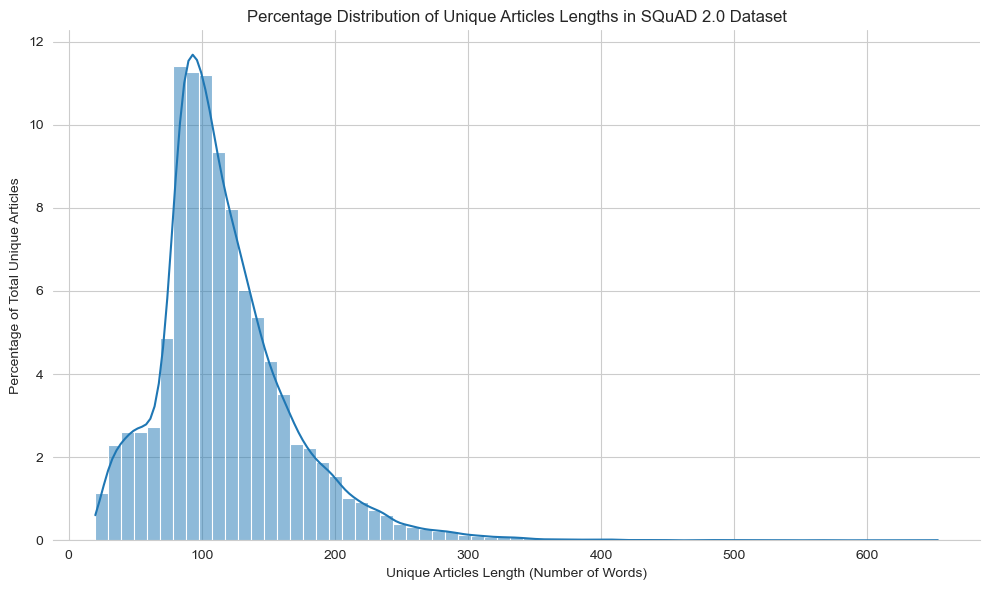

In [230]:
# Extract unique articles using a set to avoid duplicates
unique_articles = set(dataset['train']['context'])
unique_context_lengths = [len(context.split()) for context in unique_articles]

# Plot the percentage distribution of unique context lengths
plt.figure(figsize=(10, 6))
sns.histplot(unique_context_lengths, bins=65, kde=True, stat='percent')
plt.title('Percentage Distribution of Unique Articles Lengths in SQuAD 2.0 Dataset')
plt.xlabel('Unique Articles Length (Number of Words)')
plt.ylabel('Percentage of Total Unique Articles')
sns.despine(left=True)
plt.tight_layout()
plt.show()


## Normalized Distribution of Question Lengths Across SQuAD Subsets

In [ ]:
# For each subset (train, validation), calculate the length of the question and create bins
for subset in ['train', 'validation']:
    dataset[subset] = dataset[subset].map(lambda example: {"question_length": len(example['question'].split())})
    max_length = max(dataset[subset]['question_length'])
    bins = np.arange(0, max_length + 5, 5)
    bin_labels = [f"{i}-{i+4}" for i in range(0, max_length, 5)]
    dataset[subset] = dataset[subset].map(lambda example: {"length_bin": pd.cut([example['question_length']], bins=bins, labels=bin_labels, include_lowest=True)[0]})

# Combine the train and validation subsets into a single dataframe
train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])
combined_df = pd.concat([train_df, validation_df.assign(subset='validation')])
combined_df['subset'].fillna('train', inplace=True)

# Calculate the normalized distribution of question lengths
normalized_counts = combined_df.groupby(['subset', 'length_bin']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='Percentage')
normalized_counts['Length Bin'] = pd.Categorical(normalized_counts['length_bin'], categories=bin_labels, ordered=True)
normalized_counts.sort_values('Length Bin', inplace=True)

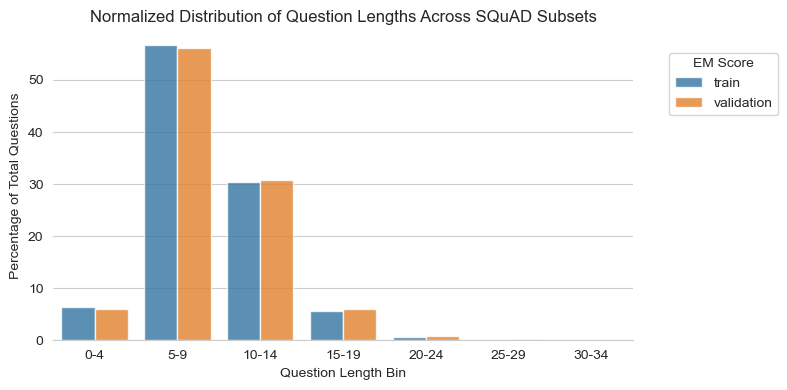

In [209]:
# Plotting the normalized distribution side by side
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4), dpi = 100)
sns.barplot(data=normalized_counts, x='Length Bin', y='Percentage', hue='subset', alpha=0.8)
plt.title('Normalized Distribution of Question Lengths Across SQuAD Subsets')
plt.xlabel('Question Length Bin')
plt.ylabel('Percentage of Total Questions')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 0.95), title='EM Score')
sns.despine(left=True)
plt.tight_layout()
plt.show()

# 3- Fine-tune Raw BigBird QA Model

In [ ]:
### Fine-tuning functions ###
tokenizer = BigBirdTokenizerFast.from_pretrained("google/bigbird-roberta-base")
model = AutoModelForQuestionAnswering.from_pretrained("google/bigbird-roberta-base")

### format the dataset for training ###

def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=512,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
        return_tensors="pt",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        if not answer["answer_start"] or not answer["text"]:
            start_positions.append(0)
            end_positions.append(0)
            continue  # skip to the next iteration
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


In [ ]:
### Split the training set into training and validation sets ###
squad = load_dataset("squad_v2", split="train")
squad = squad.train_test_split(test_size=0.2)
test = squad['test']

In [ ]:
### Preprocess the data ###
tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)
data_collator = DefaultDataCollator()


Some weights of BigBirdForQuestionAnswering were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['qa_classifier.output.LayerNorm.bias', 'qa_classifier.intermediate.dense.weight', 'qa_classifier.intermediate.dense.bias', 'qa_classifier.output.dense.weight', 'qa_classifier.qa_outputs.weight', 'qa_classifier.qa_outputs.bias', 'qa_classifier.output.dense.bias', 'qa_classifier.output.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/26064 [00:00<?, ? examples/s]

In [ ]:
# 20% warm-up sets
num_samples = len(tokenized_squad["train"])
effective_batch_size = 8 * 32 # trainig batch * gradient_accumulation_steps
total_steps = (num_samples // effective_batch_size) * 3 # 3 epochs
warmup_steps = int(0.2 * total_steps)  # As warmup_steps is set to 0.2 in training_args_2


In [ ]:
# Train torch.device("cuda")

training_args_3 = TrainingArguments(
    output_dir= "bigbird-QA-squad_v2.2", # The output directory to save the model and the training/evaluation logs
    evaluation_strategy = "epoch", # Evaluation is done at the end of each epoch and at the end of training
    save_strategy = "epoch",
    learning_rate = 3e-05, # Learning rate for training
    per_device_train_batch_size = 16, # the number of training samples processed before the model is updated, meaning the larger the batch size, the more memory space you need
    per_device_eval_batch_size= 8,# the number of evaluation samples processed before the model is updated, meaning the larger the batch size, the more memory space you need
    gradient_checkpointing=True,
    gradient_accumulation_steps = 8, # the number of gradient accumulation steps before the model is updated, meaning the larger the gradient accumulation steps, the more memory space you need
    disable_tqdm = False, # whether or not to disable the tqdm progress bars
    num_train_epochs=3, # Total number of training epochs to perform
    weight_decay=0.01, # strength of weight decay, meaning the larger the weight decay, the more regularization is applied
    warmup_steps= warmup_steps, # number of warmup steps for learning rate scheduler, meaning the larger the warmup steps, the more the learning rate will be increased
    logging_dir='./logs',
    logging_steps = 10, # number of steps to print training loss and validation loss, meaning the larger the logging steps, the less frequently the training loss and validation loss will be printed
    #total_train_batch_size = 256, # the total training batch size, meaning the larger the total training batch size, the more memory space you need
    #total_eval_batch_size = 64,
    fp16=True,
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to='wandb',

)

trainer = Trainer(
    model=model,
    args=training_args_3,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Log gradients, weights, and biases using wandb.watch
wandb.watch(model, log='all')

trainer.train()

trainer.push_to_hub()

wandb.finish()

Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch,Training Loss,Validation Loss
0,1.095500,0.971876
2,0.699300,0.858550


eval/loss,█▁▁
eval/runtime,▃▁█
eval/samples_per_second,▆█▁
eval/steps_per_second,▆█▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▅███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="docqa",

)

In [ ]:
# Train torch.device("cuda")

training_args_4 = TrainingArguments(
    output_dir= "bigbird-QA-squad_v2.3", # The output directory to save the model and the training/evaluation logs
    evaluation_strategy = "epoch", # Evaluation is done at the end of each epoch and at the end of training
    save_strategy = "epoch",
    learning_rate = 1e-05, # Learning rate for training
    per_device_train_batch_size = 16, # the number of training samples processed before the model is updated, meaning the larger the batch size, the more memory space you need
    per_device_eval_batch_size= 8,# the number of evaluation samples processed before the model is updated, meaning the larger the batch size, the more memory space you need
    gradient_checkpointing=True,
    gradient_accumulation_steps = 32, # the number of gradient accumulation steps before the model is updated, meaning the larger the gradient accumulation steps, the more memory space you need
    disable_tqdm = False, # whether or not to disable the tqdm progress bars
    num_train_epochs=3, # Total number of training epochs to perform
    weight_decay=0.01, # strength of weight decay, meaning the larger the weight decay, the more regularization is applied
    warmup_steps= warmup_steps, # number of warmup steps for learning rate scheduler, meaning the larger the warmup steps, the more the learning rate will be increased
    logging_dir='./logs',
    logging_steps = 10, # number of steps to print training loss and validation loss, meaning the larger the logging steps, the less frequently the training loss and validation loss will be printed
    #total_train_batch_size = 256, # the total training batch size, meaning the larger the total training batch size, the more memory space you need
    #total_eval_batch_size = 64,
    fp16=True,
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to='wandb',

)

trainer = Trainer(
    model=model,
    args=training_args_4,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Log gradients, weights, and biases using wandb.watch
wandb.watch(model, log='all')

trainer.train()

trainer.push_to_hub()

wandb.finish()

Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch,Training Loss,Validation Loss
0,1.789200,1.620122
1,1.487900,1.377779
2,1.388500,1.332448


eval/loss,█▂▁
eval/runtime,▁▇█
eval/samples_per_second,█▂▁
eval/steps_per_second,█▂▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,▁▂▃▄▅▅▇▇███▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
train/loss,██▇▇▅▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="docqa",

)

train/epoch,▁▂▁▂▃▃▄▅▆▆▇█
train/global_step,▁▂▁▂▃▃▄▅▆▆▇██
train/learning_rate,▂▃▁▂▂▃▄▅▆▆▇█
train/loss,█▇▂▂▅▆▇▁▅▃▃▅
train/epoch,0.25
train/global_step,100
train/learning_rate,1e-05
train/loss,1.4104


In [ ]:
# Train torch.device("cuda")

training_args_5 = TrainingArguments(
    output_dir= "bigbird-QA-squad_v2.4", # The output directory to save the model and the training/evaluation logs
    evaluation_strategy = "epoch", # Evaluation is done at the end of each epoch and at the end of training
    save_strategy = "epoch",
    learning_rate = 3e-05, # Learning rate for training
    per_device_train_batch_size = 8, # the number of training samples processed before the model is updated, meaning the larger the batch size, the more memory space you need
    per_device_eval_batch_size= 4,# the number of evaluation samples processed before the model is updated, meaning the larger the batch size, the more memory space you need
    gradient_checkpointing=True,
    gradient_accumulation_steps = 32, # the number of gradient accumulation steps before the model is updated, meaning the larger the gradient accumulation steps, the more memory space you need
    disable_tqdm = False, # whether or not to disable the tqdm progress bars
    num_train_epochs=3, # Total number of training epochs to perform
    weight_decay=0.01, # strength of weight decay, meaning the larger the weight decay, the more regularization is applied
    warmup_steps= warmup_steps, # number of warmup steps for learning rate scheduler, meaning the larger the warmup steps, the more the learning rate will be increased
    logging_dir='./logs',
    logging_steps = 10, # number of steps to print training loss and validation loss, meaning the larger the logging steps, the less frequently the training loss and validation loss will be printed
    #total_train_batch_size = 256, # the total training batch size, meaning the larger the total training batch size, the more memory space you need
    #total_eval_batch_size = 64,
    fp16=True,
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to='wandb',

)

trainer = Trainer(
    model=model,
    args=training_args_5,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Log gradients, weights, and biases using wandb.watch
wandb.watch(model, log='all')

trainer.train()

trainer.push_to_hub()

wandb.finish()

Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch,Training Loss,Validation Loss
0,1.324500,1.174619
1,1.008900,0.913305
2,0.840800,0.895101


eval/loss,█▁▁
eval/runtime,▁█▅
eval/samples_per_second,█▁▄
eval/steps_per_second,█▁▄
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,▁▂▃▄▅▅▆▇██▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
train/loss,█▇▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
tokenizer = BigBirdTokenizerFast.from_pretrained("google/bigbird-roberta-base")
model = AutoModelForQuestionAnswering.from_pretrained("google/bigbird-roberta-base")

tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)
data_collator = DefaultDataCollator()

# 20% warm-up sets
num_samples = len(tokenized_squad["train"])
effective_batch_size = 8 * 32 # trainig batch * gradient_accumulation_steps
total_steps = (num_samples // effective_batch_size) * 3 # 3 epochs
warmup_steps = int(0.2 * total_steps)  # As warmup_steps is set to 0.2 in training_args_2



# start a new wandb run to track this script
wandb.init(
    project="docqa",

)

# 4- Evaluate Fine-tuned models' performance

In [53]:
# split SQuAD 2 on Validation 
data = load_dataset("squad_v2", split="validation")

task_evaluator = evaluator("question-answering")

# models list
models_dict = {
    "roberta-base": "deepset/roberta-base-squad2",
    "deberta-v3-large": "deepset/deberta-v3-large-squad2",
    "albert-base-v2": "squirro/albert-base-v2-squad_v2",
    "bigbird-roberta-base": "FredNajjar/bigbird-QA-squad_v2.2"
}


Found cached dataset squad_v2 (C:/Users/Fred/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


In [200]:

# results 
eval_results_dict = {}

for model_name, model_path in tqdm(models_dict.items()):
    
    eval_results = task_evaluator.compute(
        model_or_pipeline=model_path,
        data=data,
        metric="squad_v2",
        squad_v2_format=True)

    # store results 
    eval_results_dict[model_name] = eval_results

print(eval_results_dict)

# eval_results_dict = {'roberta-base': {'exact': 79.92082877116145, 'f1': 82.9963457626089, 'total': 11873, 'HasAns_exact': 77.91835357624831, 'HasAns_f1': 84.07820736158186, 'HasAns_total': 5928, 'NoAns_exact': 81.91757779646763, 'NoAns_f1': 81.91757779646763, 'NoAns_total': 5945, 'best_exact': 79.92082877116145, 'best_exact_thresh': 0.996823787689209, 'best_f1': 82.99634576260925, 'best_f1_thresh': 0.996823787689209, 'total_time_in_seconds': 225.06594863400005, 'samples_per_second': 52.753426593677, 'latency_in_seconds': 0.018956114599006153}, 
#                      'deberta-v3-large': {'exact': 87.2146887896909, 'f1': 90.60677013304978, 'total': 11873, 'HasAns_exact': 83.13090418353576, 'HasAns_f1': 89.92479449893742, 'HasAns_total': 5928, 'NoAns_exact': 91.28679562657696, 'NoAns_f1': 91.28679562657696, 'NoAns_total': 5945, 'best_exact': 87.2146887896909, 'best_exact_thresh': 0.999616265296936, 'best_f1': 90.60677013305009, 'best_f1_thresh': 0.999616265296936, 'total_time_in_seconds': 726.4585640880002, 'samples_per_second': 16.343671321302992, 'latency_in_seconds': 0.061185762999073544}, 
#                      'albert-base-v2': {'exact': 78.27002442516634, 'f1': 81.59837836217132, 'total': 11873, 'HasAns_exact': 74.24089068825911, 'HasAns_f1': 80.90714343691984, 'HasAns_total': 5928, 'NoAns_exact': 82.28763666947015, 'NoAns_f1': 82.28763666947015, 'NoAns_total': 5945, 'best_exact': 78.27002442516634, 'best_exact_thresh': 0.9966533780097961, 'best_f1': 81.5983783621717, 'best_f1_thresh': 0.9966533780097961, 'total_time_in_seconds': 245.1675431249996, 'samples_per_second': 48.42810695356402, 'latency_in_seconds': 0.020649165596310925}, 
#                      'bigbird-roberta-base': {'exact': 76.78766950223195, 'f1': 80.14512218825952, 'total': 11873, 'HasAns_exact': 75.20242914979757, 'HasAns_f1': 81.92696284433303, 'HasAns_total': 5928, 'NoAns_exact': 78.36837678721615, 'NoAns_f1': 78.36837678721615, 'NoAns_total': 5945, 'best_exact': 76.78766950223195, 'best_exact_thresh': 0.9957776069641113, 'best_f1': 80.14512218825993, 'best_f1_thresh': 0.9957776069641113, 'total_time_in_seconds': 262.50442789399995, 'samples_per_second': 45.22971324809177, 'latency_in_seconds': 0.022109359714815122}}

# sort eval_results_dict by extract score
sorted_eval_results_dict = {k: v for k, v in sorted(eval_results_dict.items(), key=lambda item: item[1]['exact'], reverse=True)}

In [196]:

# Create a list of dictionaries for all models and their scores
data = [{'Model': model, 'EM': scores['exact'], 'F1': scores['f1']} 
        for model, scores in sorted_eval_results_dict.items()]

# Convert the list of dictionaries to a DataFrame
scores_table = pd.DataFrame(data)

# Display the DataFrame
scores_table.head()


,Model,EM,F1
0,deberta-v3-large,87.214689,90.606770
1,roberta-base,79.920829,82.996346
2,albert-base-v2,78.270024,81.598378
3,bigbird-roberta-base,76.787670,80.145122


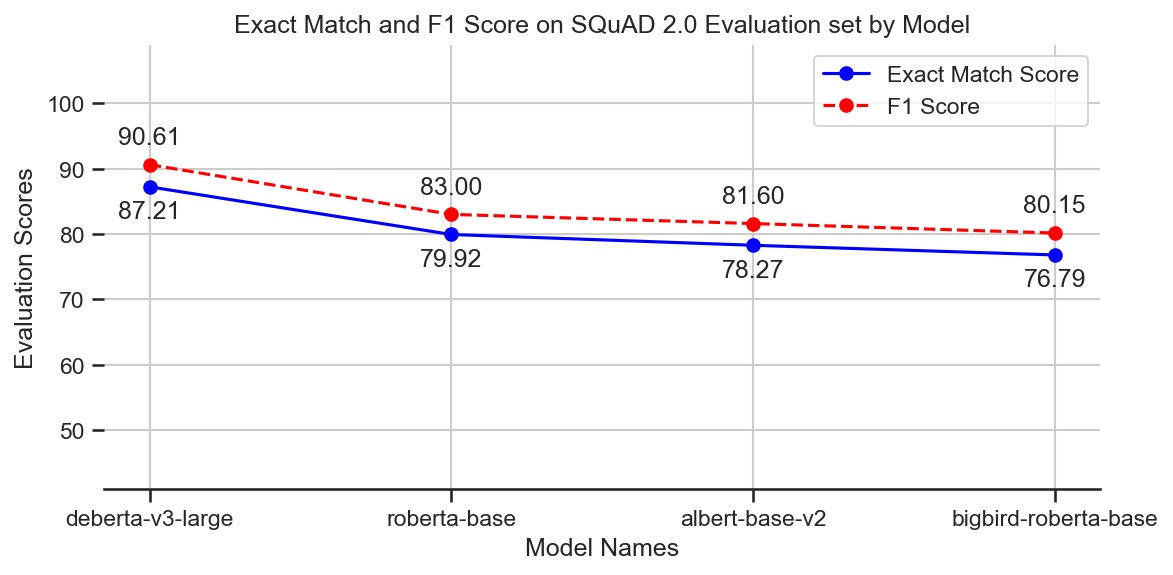

In [190]:
# Exact Match and F1 scores
exact_match_scores = [result['exact'] for result in sorted_eval_results_dict.values()]
f1_scores = [result['f1'] for result in sorted_eval_results_dict.values()]
models = list(sorted_eval_results_dict.keys())

# Plotting both the Exact Match and F1 scores
plt.figure(figsize=(8, 4), dpi = 150)
plt.plot(models, exact_match_scores, marker='o', color='blue', label='Exact Match Score')
plt.plot(models, f1_scores, marker='o', color='red', linestyle='dashed', label='F1 Score')

# Adding data labels to the points
for i, txt in enumerate(exact_match_scores):
    plt.annotate(f'{txt:.2f}', (models[i], exact_match_scores[i]), textcoords="offset points", xytext=(0,-15), ha='center')
for i, txt in enumerate(f1_scores):
    plt.annotate(f'{txt:.2f}', (models[i], f1_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Adding a legend, title, and axis labels
plt.title('Exact Match and F1 Score on SQuAD 2.0 Evaluation set by Model')
plt.xlabel('Model Names')
plt.ylabel('Evaluation Scores')
plt.ylim(41,109)
plt.legend()
plt.grid(True)
sns.despine(left=True)
plt.tight_layout()
plt.show()



# 5- Analyse model performance

In [6]:
# Load the metrics
f1_metric = load_metric('squad_v2')
em_metric = load_metric('squad_v2')

# Initialize pipelines
nlp_pipelines = {}
for model_name, model_path in models_dict.items():
    model = AutoModelForQuestionAnswering.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    nlp_pipelines[model_name] = pipeline("question-answering", 
                                         model=model, 
                                         tokenizer=tokenizer, 
                                         device=0 if torch.cuda.is_available() else -1)

# Prepare the DataFrame
df_results = pd.DataFrame()

# Predict and compute metrics for each question
for i, item in tqdm(enumerate(data)):
    for model_name, nlp in nlp_pipelines.items():
        QA_input = {
            'question': item['question'],
            'context': item['context']
        }
        try:
            prediction = nlp(QA_input, handle_impossible_answer=True, top_k=1)
            formatted_prediction = [{
                "id": item['id'],
                "prediction_text": prediction['answer'],
                "no_answer_probability": 0.0 if prediction['answer'] else 1.0
            }]
            formatted_reference = [{
                "id": item['id'],
                "answers": item['answers']
            }]
            f1_score = f1_metric.compute(predictions=formatted_prediction, references=formatted_reference)['f1']
            em_score = em_metric.compute(predictions=formatted_prediction, references=formatted_reference)['exact']  

            # Add results to DataFrame
            df_results = df_results.append({
                'Question ID': i,
                'Model': model_name,
                'Question': item['question'],
                'Context': item['context'],
                'Predicted Answer': prediction['answer'],
                'Ground Truth Answer': item['answers']['text'][0] if item['answers']['text'] else '',
                'Score': prediction['score'],
                'Start Position': prediction['start'],
                'End Position': prediction['end'],
                'F1 Score': f1_score,
                'EM Score': em_score,
                'No Answer Probability': formatted_prediction[0]['no_answer_probability']
            }, ignore_index=True)
        except Exception as e:
            print(f"Error for model {model_name} on question {item['id']}: {str(e)}")

# Save results to CSV
df_results.to_csv('squad2_model_evaluation_analysis.csv', index=False)


0it [00:00, ?it/s]Attention type 'block_sparse' is not possible if sequence_length: 172 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...
11873it [47:57,  4.13it/s]


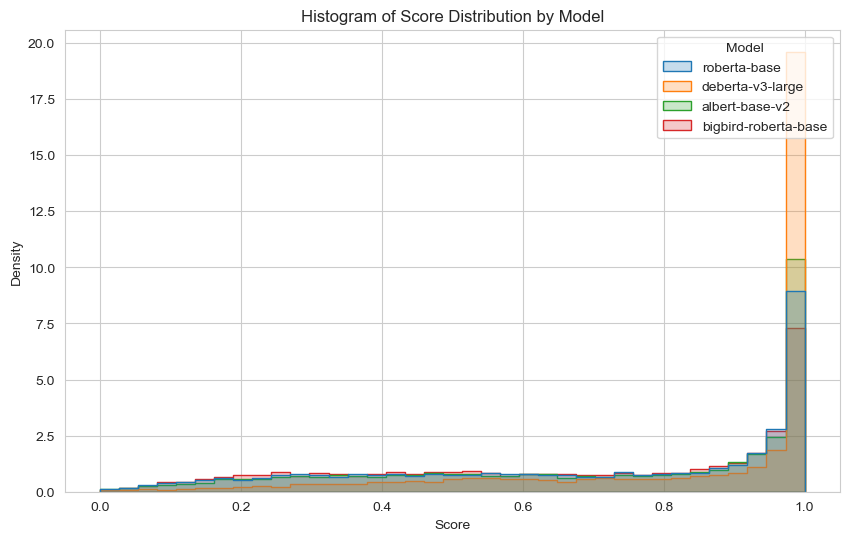

In [33]:


# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a histogram distribution of 'Score' for each model
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Score', hue='Model', element='step', stat='density', common_norm=False)

# Set the title and labels for the plot
plt.title('Histogram of Score Distribution by Model')
plt.xlabel('Score')
plt.ylabel('Density')

# Show the plot
plt.show()


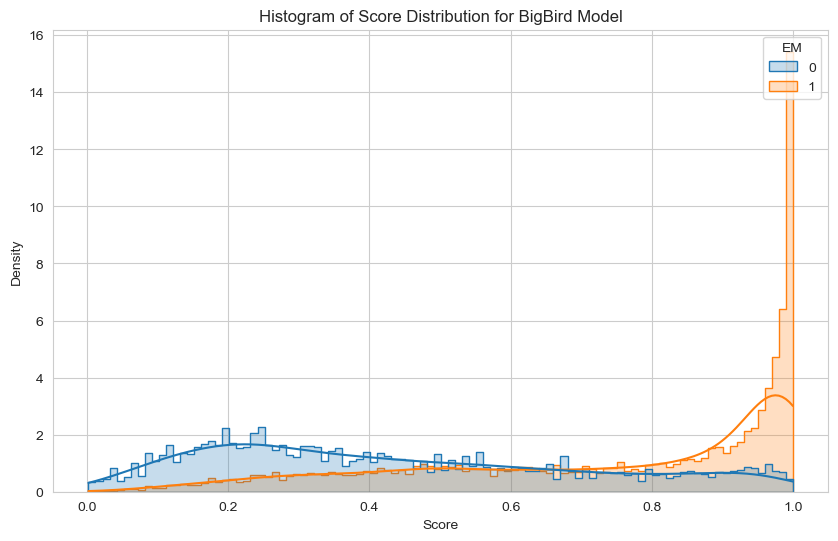

In [251]:

# Filter for only the BigBird model
bigbird_data = data[data['Model'] == 'bigbird-roberta-base']

# breakdown by EM vs not EM 
bigbird_data['EM'] = bigbird_data['EM Score'].apply(lambda x: 1 if x == 100 else 0)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a histogram distribution of 'Score' for the BigBird model
plt.figure(figsize=(10, 6))
sns.histplot(data=bigbird_data, x='Score', bins=100, kde=True, stat='density', hue='EM', element='step', common_norm=False)

# Set the title and labels for the plot
plt.title('Histogram of Score Distribution for BigBird Model')
plt.xlabel('Score')
plt.ylabel('Density')

# Show the plot
plt.show()


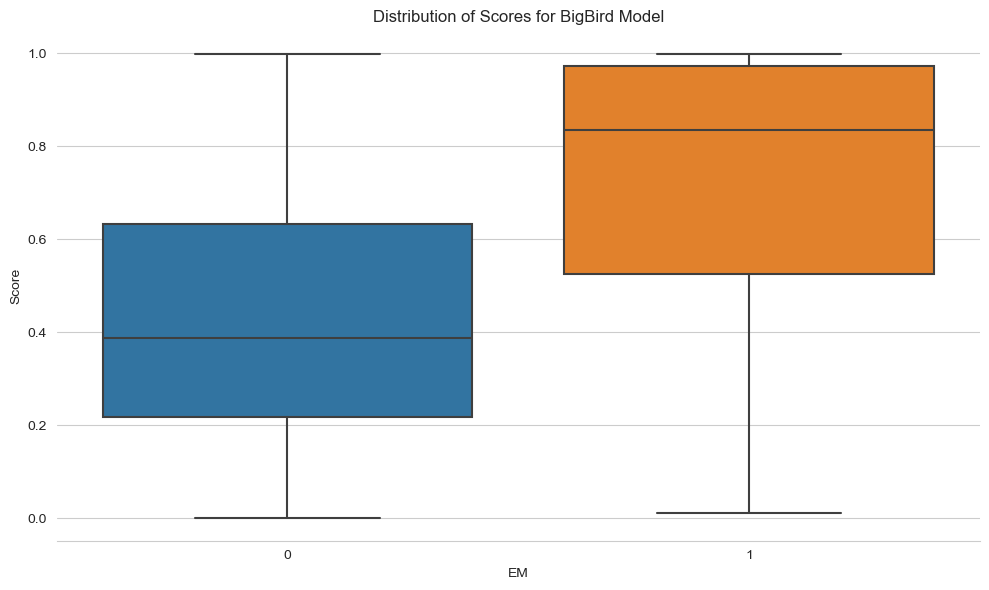

In [260]:
# boxplot showing the distribution of scores for EM vs not EM
plt.figure(figsize=(10, 6))
sns.boxplot(data=bigbird_data, x='EM', y='Score')
plt.setp(plt.gca().artists, alpha=0.8)
plt.title('Distribution of Scores for BigBird Model')
plt.xlabel('EM')
plt.ylabel('Score')
sns.despine(left=True)
plt.tight_layout()
plt.show()


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data into a pandas DataFrame
data = pd.read_csv('squad2_model_evaluation_analysis.csv')


<Figure size 1200x800 with 0 Axes>

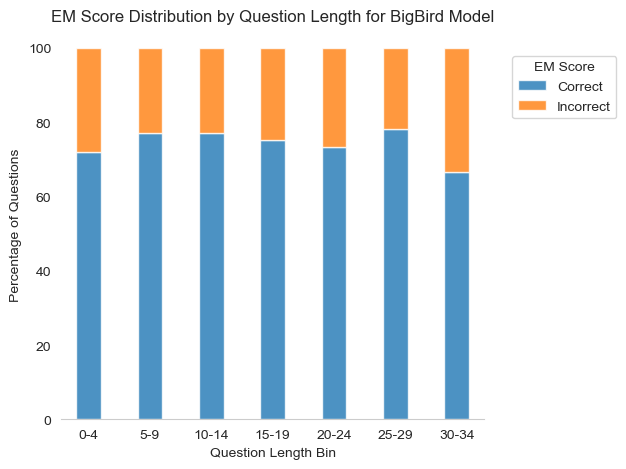

In [202]:
# Calculate the length of the question in words
bigbird_data = data[data['Model'] == 'bigbird-roberta-base']
bigbird_data['Question Length'] = bigbird_data['Question'].apply(lambda q: len(q.split()))

# Define bins and bin labels for question length
max_length = bigbird_data['Question Length'].max()
bins =  np.arange(-1, bigbird_data['Question Length'].max() + 5, 5)
bin_labels = [f"{i}-{i+4}" for i in range(0, bigbird_data['Question Length'].max(), 5)]
bigbird_data['Length Bin'] = pd.cut(bigbird_data['Question Length'], bins=bins, labels=bin_labels, include_lowest=True)

# Group by Model, Length Bin, and count EM Scores
grouped = bigbird_data.groupby('Length Bin')['EM Score'].value_counts().unstack().fillna(0)
grouped.columns = grouped.columns.map(int)
grouped = grouped[[100.0, 0.0]]
grouped['Total'] = grouped.sum(axis=1)

# Plotting
plt.figure(figsize=(12, 8))
percentage_data = (grouped.div(grouped['Total'], axis=0) * 100).drop(columns='Total')
percentage_data.plot(kind='bar', stacked=True, width=0.4, alpha=0.8)
plt.title('EM Score Distribution by Question Length for BigBird Model')
plt.xlabel('Question Length Bin')
plt.ylabel('Percentage of Questions')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 0.95), title='EM Score', labels = ['Correct', 'Incorrect'])
plt.xticks(rotation=0)
sns.despine(left=True)  
plt.tight_layout()
plt.show()

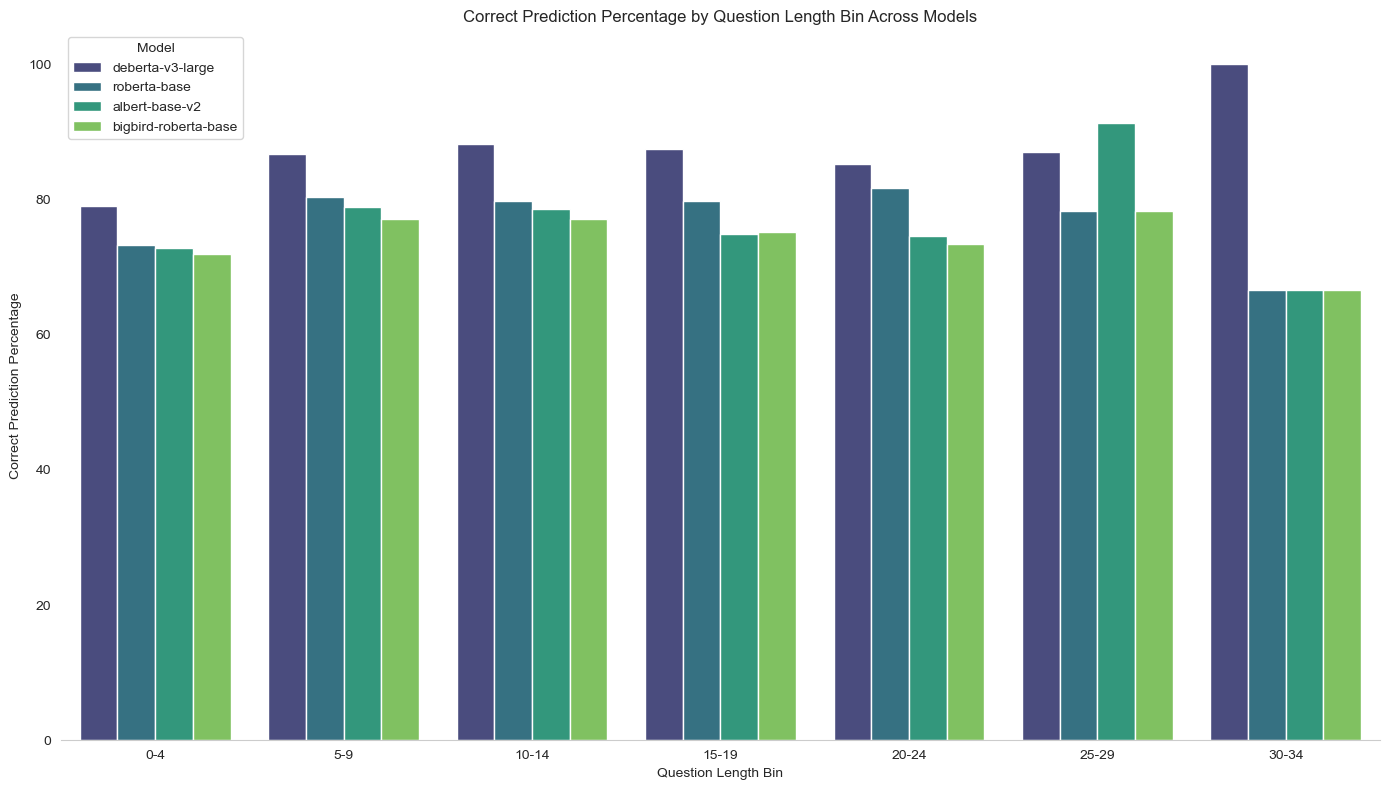

In [193]:
# Calculate the length of the question in words
data['Question Length'] = data['Question'].apply(lambda q: len(q.split()))

# Define bins and bin labels for question length
bins = np.arange(-1, data['Question Length'].max() + 5, 5)
bin_labels = [f"{i}-{i+4}" for i in range(0, data['Question Length'].max(), 5)]
data['Length Bin'] = pd.cut(data['Question Length'], bins=bins, labels=bin_labels, include_lowest=True)

# Group by Model, Length Bin, and count EM Scores
grouped = data.groupby(['Model', 'Length Bin'])['EM Score'].value_counts().unstack().fillna(0)
grouped.columns = grouped.columns.map(int)  # Ensure correct format for EM Score
grouped['Total'] = grouped.sum(axis=1)
grouped['Correct Percentage'] = (grouped[100] / grouped['Total']) * 100
grouped = grouped.reset_index()

# Define and order the models
model_order = ['deberta-v3-large', 'roberta-base', 'albert-base-v2', 'bigbird-roberta-base']
grouped['Model'] = pd.Categorical(grouped['Model'], categories=model_order, ordered=True)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x='Length Bin', y='Correct Percentage', hue='Model', data=grouped, palette='viridis', hue_order=model_order)
plt.title('Correct Prediction Percentage by Question Length Bin Across Models')
plt.xlabel('Question Length Bin')
plt.ylabel('Correct Prediction Percentage')
plt.legend(title='Model')
sns.despine(left=True)
plt.tight_layout()
plt.show()
